In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 30]

In [4]:
import fastai as fai
from fastai.basic_data import DataLoader
from data_loader import *
import numpy as np
from torch.utils.data import SubsetRandomSampler
from model import *
from model_bn import *
from torch import optim
import dill
import papermill as pm
from main import *
import pandas as pd

In [5]:
optimizer = 'Adam'
num_workers=8
maxsize=100000
batch_size=2048
n_epochs=500
batch_norm = True
dataset='data/speedup_dataset.h5'

In [6]:
train_dl, val_dl = train_dev_split(dataset, batch_size, num_workers, maxsize)

db = fai.basic_data.DataBunch(train_dl, val_dl)

In [7]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size)
else:
    model = Model(input_size, output_size)
    
criterion = nn.MSELoss()

l = fai.Learner(db, model, loss_func=criterion)

if optimizer == 'SGD':
    l.opt_func = optim.SGD


In [12]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


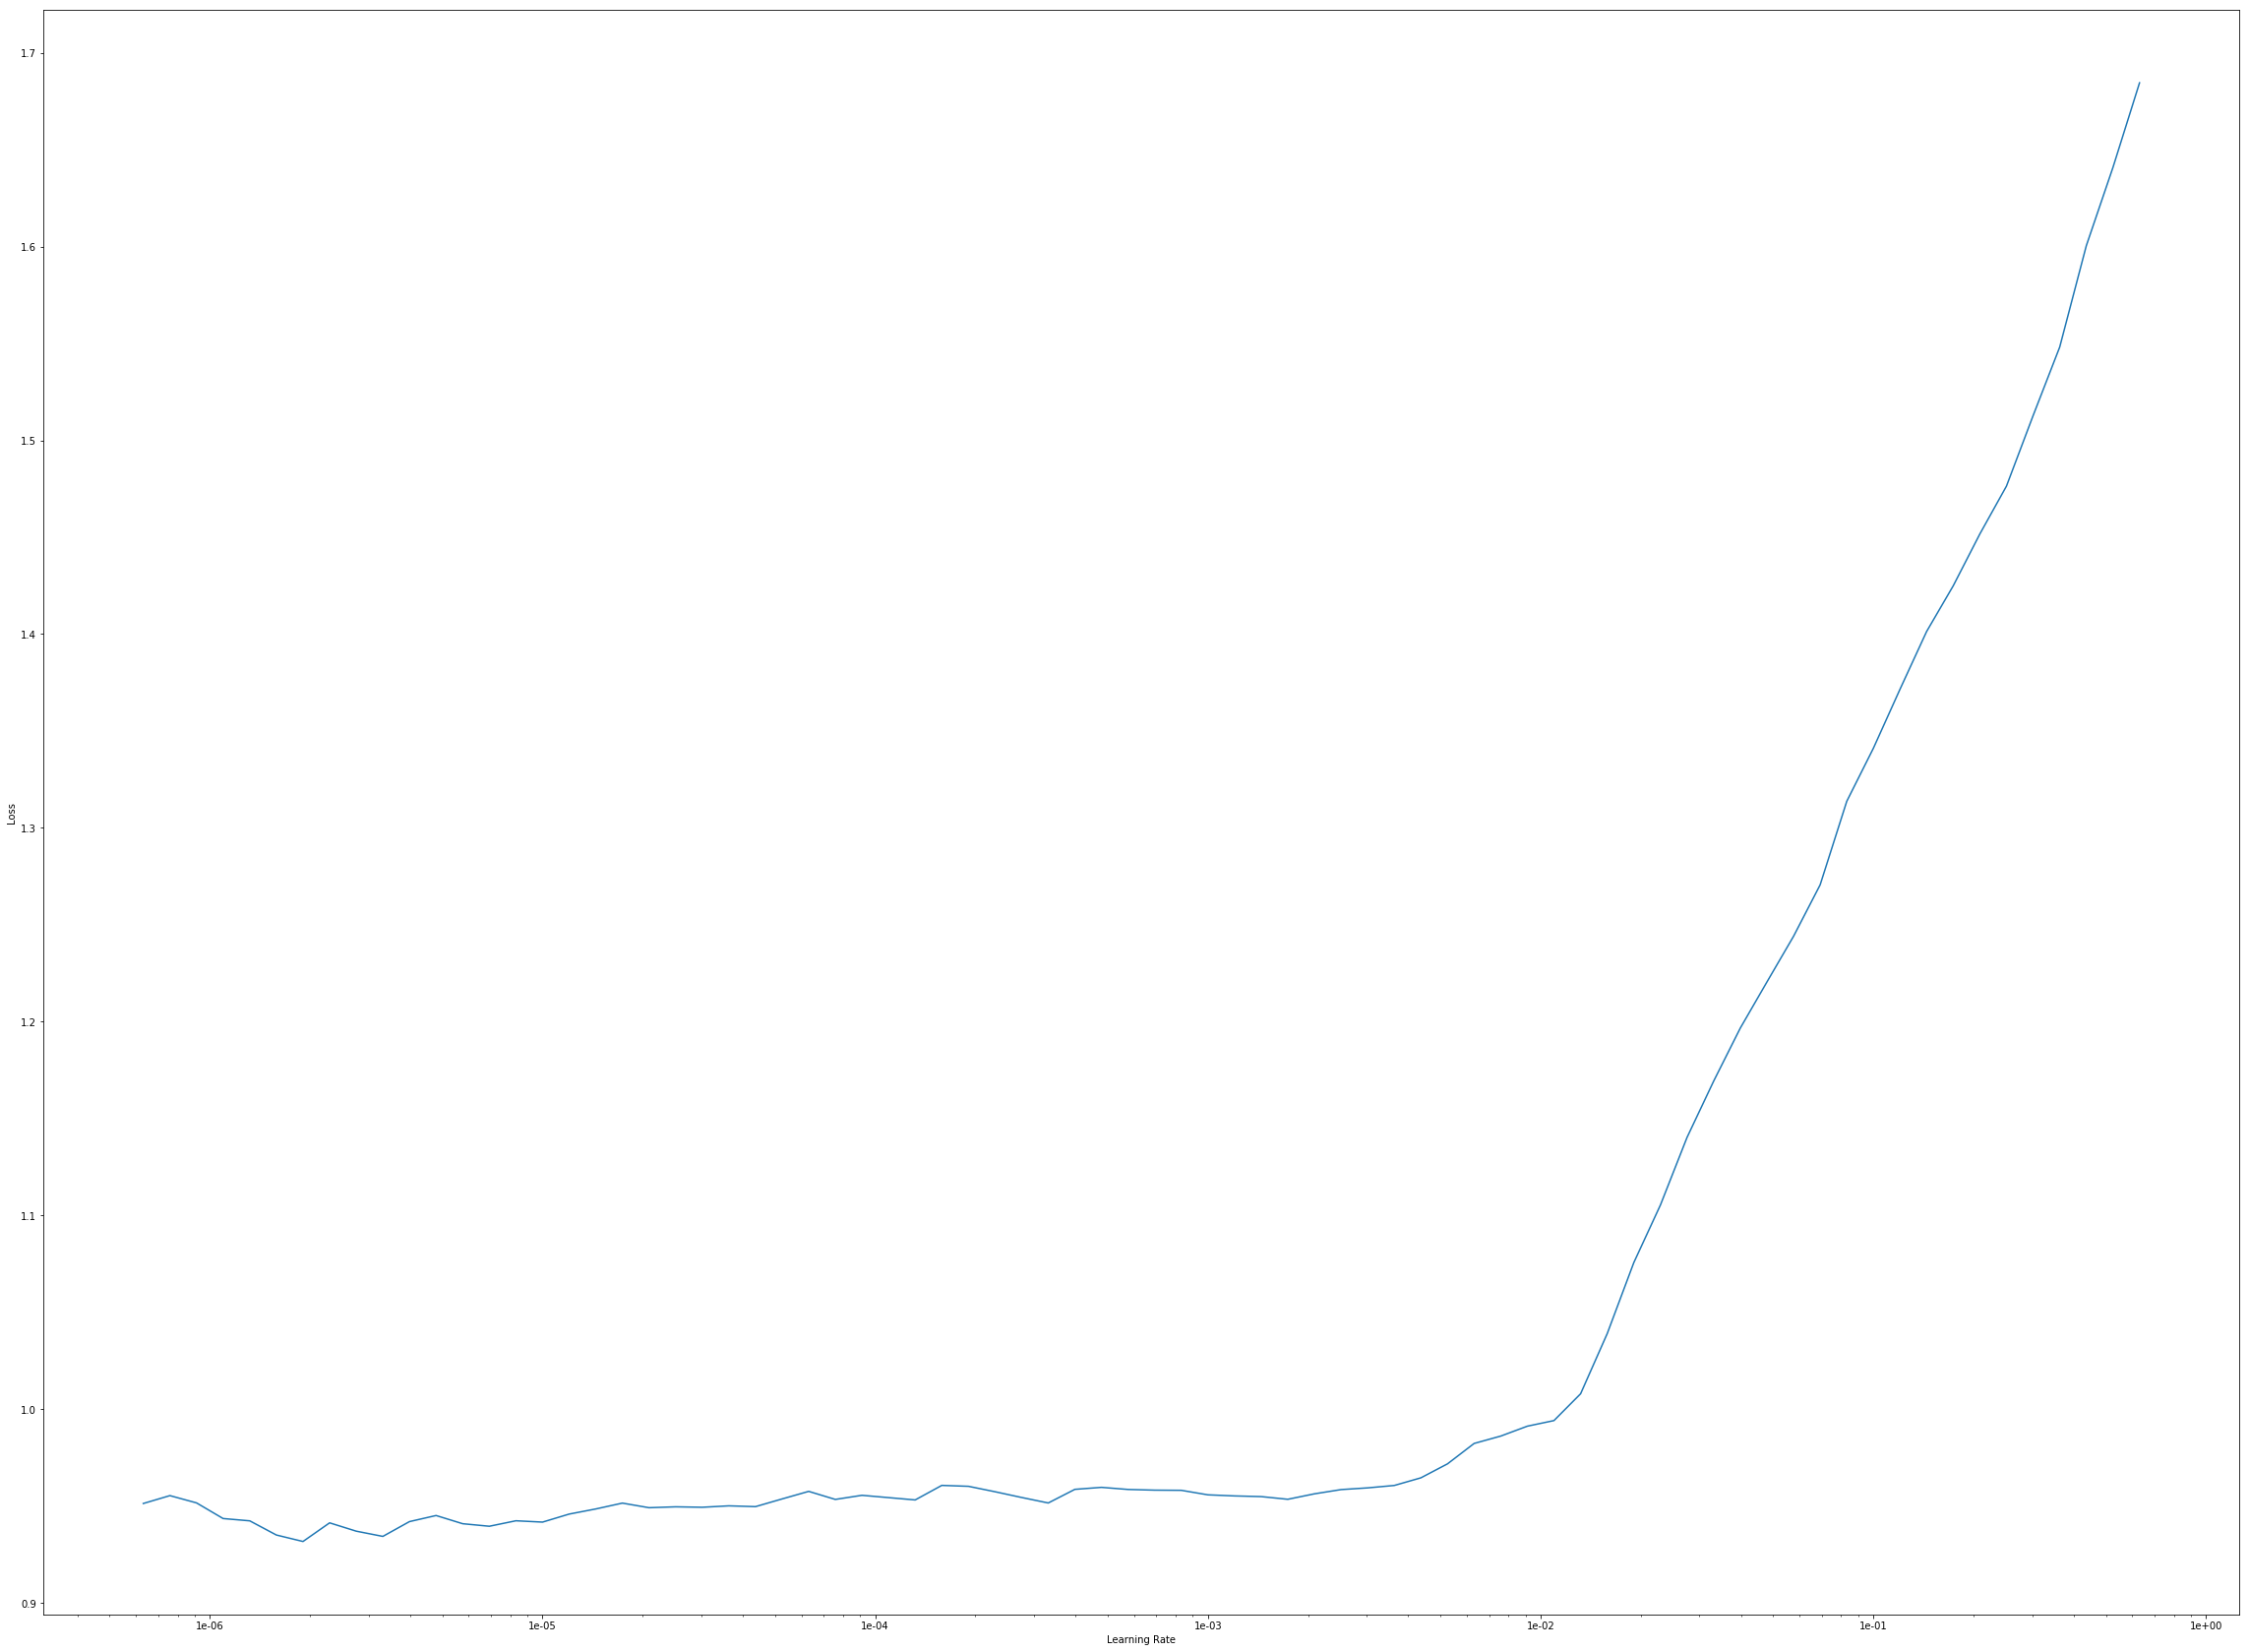

In [13]:
l.recorder.plot()

In [14]:
lr = 0.001

In [15]:
l.fit_one_cycle(300, lr)

epoch,train_loss,valid_loss
1,0.962619,0.915109
2,0.954268,0.922069
3,0.948310,0.933422
4,0.959162,0.927936
5,0.955292,0.962480
6,0.955686,0.983531
7,0.959359,0.964114
8,0.963162,0.961883
9,0.959086,1.133870
10,0.958194,0.910141


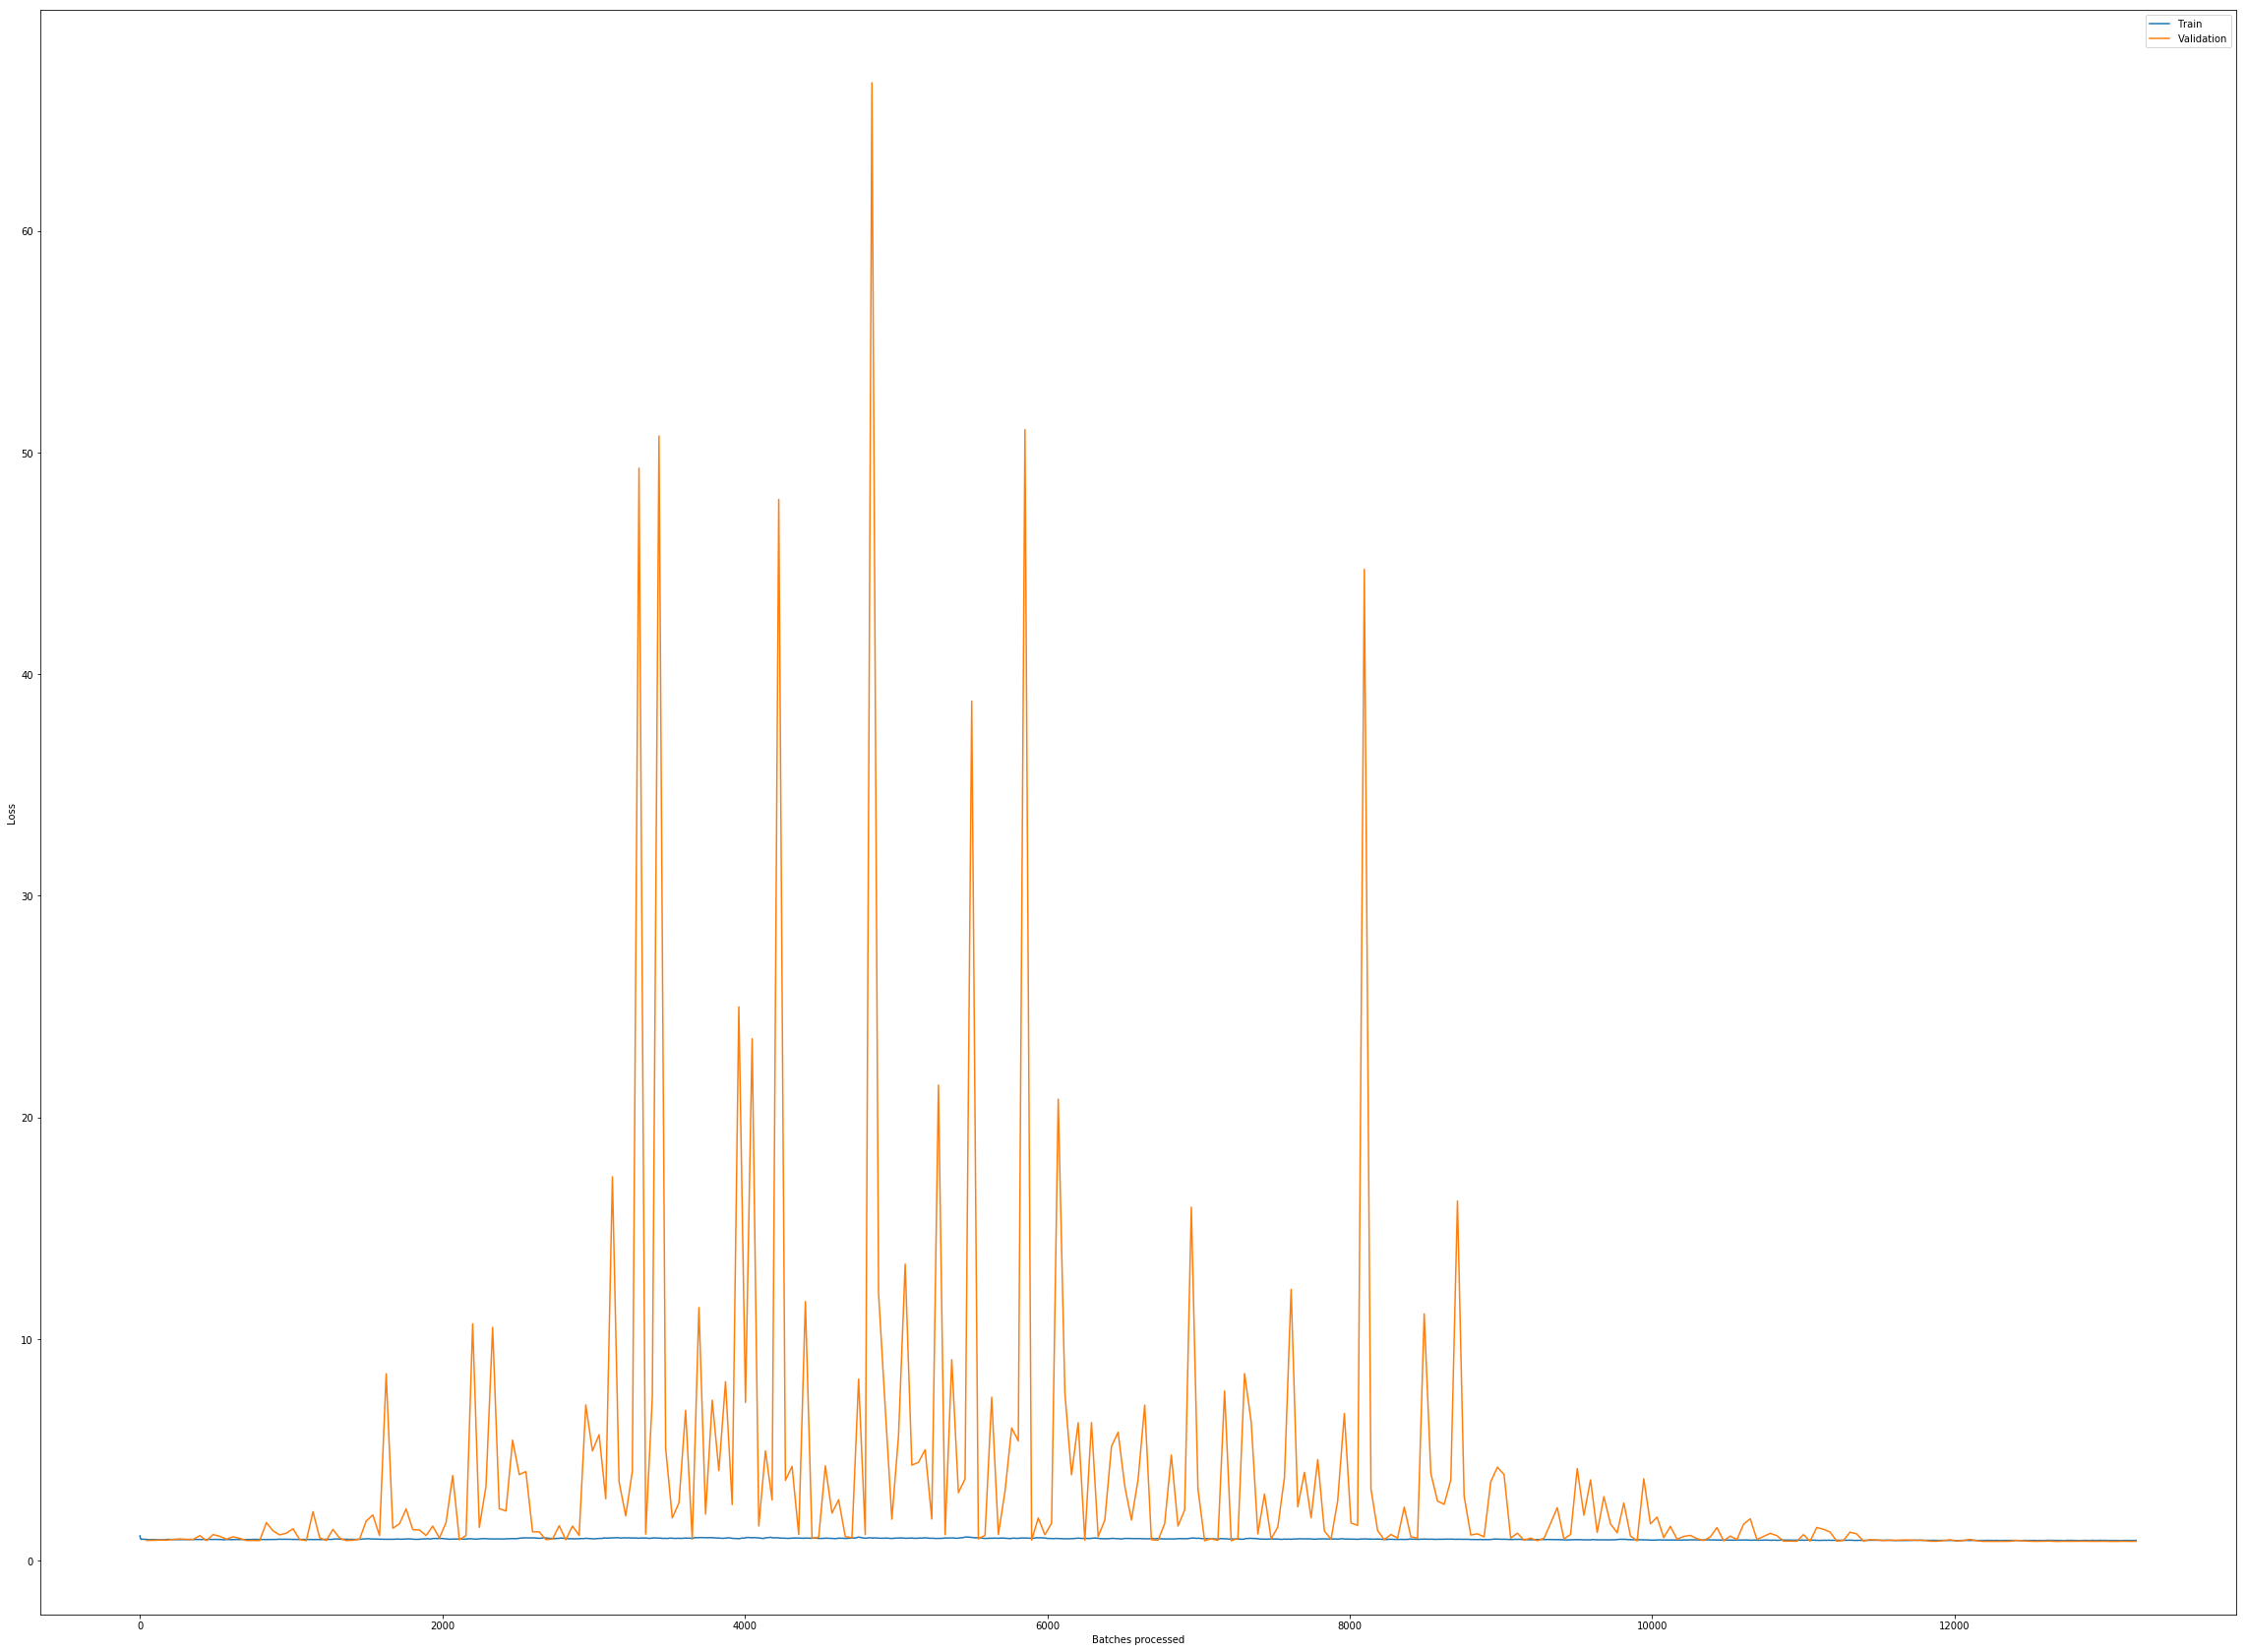

In [18]:
l.recorder.plot_losses()

In [17]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_mse")

In [8]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_mse") 

In [9]:
val_df = pd.DataFrame()
train_df = pd.DataFrame()

preds, targets = l.get_preds(fai.basic_data.DatasetType.Valid)

preds = preds.reshape((-1,)).numpy()
targets = targets.reshape((-1,)).numpy()

val_df['pred'] = preds
val_df['target'] = targets
val_df['abs_diff'] = np.abs(preds - targets)
val_df['APE'] = np.abs(val_df.target - val_df.pred)/val_df.target * 100

preds, targets = l.get_preds(fai.basic_data.DatasetType.Train)

preds = preds.reshape((-1,)).numpy()
targets = targets.reshape((-1,)).numpy()

train_df['pred'] = preds
train_df['target'] = targets
train_df['abs_diff'] = np.abs(preds - targets)
train_df['APE'] = np.abs(train_df.target - train_df.pred)/train_df.target * 100

In [19]:
val_df.abs_diff.describe()

count    10000.000000
mean         0.650753
std          0.695865
min          0.000062
25%          0.201365
50%          0.428166
75%          0.836580
max          5.915672
Name: abs_diff, dtype: float64

In [11]:
val_df.APE.describe()

count    10000.000000
mean        75.867996
std        140.273727
min          0.008468
25%         14.071760
50%         31.454399
75%         65.824497
max       1650.147095
Name: APE, dtype: float64